# LSTM for PV forecast
利用LSTM神经网络进行时间序列数据预测分析，预测未来光伏出力。

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
# read data
df = pd.read_csv('../../data/raw_pvdaq/pvdaq_2012_2014_15min.csv', header=0, infer_datetime_format=True, parse_dates=['Date-Time'], index_col=['Date-Time'])

raw data参数中有许多特征，这里只选取物理特征，因为电气特征实际上应该算是物理特征的因变量：

电气特征有

| ac_current | ac_power | ac_voltage | dc_current | dc_power | dc_voltage | inverter_error_code | power_factor |
| ---------- | -------- | ---------- | ---------- | -------- | ---------- | ------------------- | ------------ |

物理特征有
| ambient_temp | inverter_temp | module_temp | poa_irradiance | relative_humidity | wind_direction | wind_speed |
| ------------ | ------------- | ----------- | -------------- | ----------------- | -------------- | ---------- |


选取物理特征：环境温度、逆变器温度、模块温度、辐照度(、相对湿度、风向、风速)；

输出则为光伏阵列的直流输出功率。


In [4]:
features = ['ambient_temp', 'inverter_temp', 'module_temp', 'poa_irradiance', 'relative_humidity', 'wind_direction', 'wind_speed']
# features = ['ambient_temp', 'inverter_temp', 'module_temp', 'poa_irradiance']
target = ['dc_power']
time_indexes = [df.index.hour, df.index.month]
time_indexes

[Int64Index([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,
             ...
             21, 21, 22, 22, 22, 22, 23, 23, 23, 23],
            dtype='int64', name='Date-Time', length=105231),
 Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
             ...
             12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
            dtype='int64', name='Date-Time', length=105231)]

data = [feature1; feature2; ... ; feature7; hour; month; DC power];

shape = (26304, 10)

In [5]:
# feature columns stacking
data = []
for feature in features:
  feature_col = df[feature].values.reshape(-1, 1)
  data.append(feature_col)
for index in time_indexes:
  index_col = index.values.reshape(-1, 1)
  data.append(index_col)
data.append(np.maximum(df[target].values.reshape(-1,1),0))
data = np.hstack((data))

**输入数据处理**

LSTM模型需要输入3D张量作为输入，形状为（样本数，时间步长，特征数）。

In [6]:
timesteps = 32
n_data = np.size(data,0) # 26304
n_feature = len(features) # 7
index = data[:,n_feature:n_feature+2]
X = data[:,0:n_feature]
y = data[:,-1]
X, y

(array([[ 4.78055734e+00,  1.70000000e+01,  1.41666818e+00, ...,
          4.22310000e+01,  3.06720000e+02,  9.91981760e-01],
        [ 4.62889066e+00,  1.70000000e+01,  4.50001436e-01, ...,
          4.35310000e+01,  3.06698000e+02,  4.35864000e-01],
        [ 4.41500175e+00,  1.60000000e+01, -4.72220860e-01, ...,
          4.51000000e+01,  3.06698000e+02,  4.66709760e-01],
        ...,
        [ 4.66112548e-01,  1.10000000e+01,  2.38890308e-01, ...,
          5.54130000e+01,  3.51675000e+02,  2.26202240e-01],
        [ 3.20001426e-01,  1.10000000e+01, -4.22220856e-01, ...,
          5.41440000e+01,  3.51698000e+02,  2.06532480e-01],
        [ 3.88902920e-02,  1.00000000e+01, -1.18888758e+00, ...,
          5.47310000e+01,  3.51698000e+02,  6.67877760e-01]]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [7]:
X_train, y_train, index_train = X[:-200,:], y[:-200], df.index[:-200]
X_test, y_test, index_test = X[-200:,:], y[-200:], df.index[-200:]

# X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y, df.index,test_size=0.05)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# 评估模型性能

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print('均方误差 (MSE):', mse)
index_train, index_test

均方误差 (MSE): 15111915.705839777


(DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 00:15:00',
                '2012-01-01 00:30:00', '2012-01-01 00:45:00',
                '2012-01-01 01:00:00', '2012-01-01 01:15:00',
                '2012-01-01 01:30:00', '2012-01-01 01:45:00',
                '2012-01-01 02:00:00', '2012-01-01 02:15:00',
                ...
                '2014-12-29 20:00:00', '2014-12-29 20:15:00',
                '2014-12-29 20:30:00', '2014-12-29 20:45:00',
                '2014-12-29 21:00:00', '2014-12-29 21:15:00',
                '2014-12-29 21:30:00', '2014-12-29 21:45:00',
                '2014-12-29 22:00:00', '2014-12-29 22:15:00'],
               dtype='datetime64[ns]', name='Date-Time', length=105031, freq=None),
 DatetimeIndex(['2014-12-29 22:30:00', '2014-12-29 22:45:00',
                '2014-12-29 23:00:00', '2014-12-29 23:15:00',
                '2014-12-29 23:30:00', '2014-12-29 23:45:00',
                '2014-12-30 00:00:00', '2014-12-30 00:15:00',
                '2014-12-30

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from math import sqrt
#回归评价指标
# calculate MSE 均方误差
mse = mean_squared_error(y_test,y_pred)
# calculate RMSE 均方根误差
rmse = sqrt(mean_squared_error(y_test, y_pred))
#calculate MAE 平均绝对误差
mae=mean_absolute_error(y_test,y_pred)
#calculate R square
r_square=r2_score(y_test,y_pred)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)
print('R_square: %.6f' % r_square)

均方误差: 15111915.705840
均方根误差: 3887.404752
平均绝对误差: 1683.194855
R_square: 0.569883


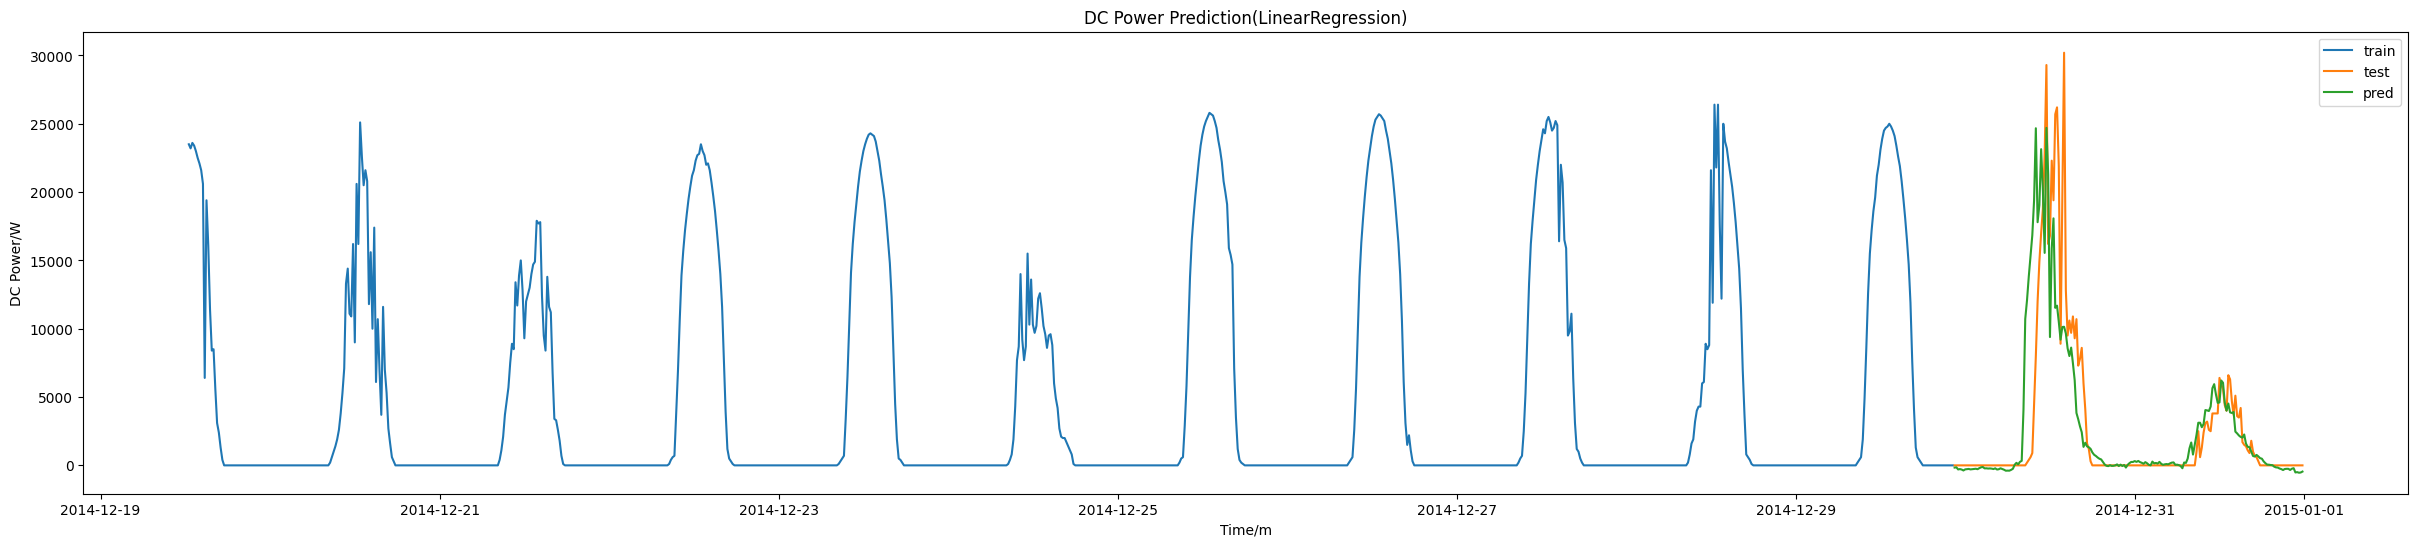

In [8]:
plt.figure(figsize=(30, 6))
plt.xlabel('Time/m')
plt.ylabel('DC Power/W')
plt.title("DC Power Prediction(LinearRegression)")
plt.plot(index_train[-1000:], y_train[-1000:],label='train')
plt.plot(index_test, y_test,label='test')
plt.plot(index_test, y_pred,label='pred')
plt.legend()
# plt.savefig('../../figures/PV forecast/DC Power Prediction(LinearRegression).png')

In [9]:
# df_train = pd.DataFrame({'index_train': index_train , 'y_train': y_train})
# df_test = pd.DataFrame({'index_test': index_test,'y_test': y_test})
# df_pred = pd.DataFrame({'index_test': index_test, 'y_pred':y_pred})
# df_train.to_csv('../../data/train.csv', index=False)
# df_test.to_csv('../../data/test.csv', index=False)
# df_pred.to_csv('../../data/pred.csv', index=False)

In [10]:
# def prepare_data(X, y, time_steps):
#     X_data, y_data = [], []
#     for i in range(len(X) - time_steps):
#         X_data.append(X[i:i+time_steps])
#         y_data.append(y[i+time_steps])
#     return np.array(X_data), np.array(y_data)

In [11]:
# Xin,yin = prepare_data(X, y,timesteps)
# y_scaled = yin/np.max(yin)
# Xin.shape, yin.shape

In [12]:
# # X_train, y_train = Xin[:-2000,:], yin[:-2000]
# # X_val, y_val = Xin[-2000:-1000,:], yin[-2000:-1000]
# # X_test, y_test = Xin[-1000:,:], yin[-1000:]
# X_train, y_train = Xin[:-2000,:], y_scaled[:-2000]
# X_val, y_val = Xin[-2000:-1000,:], y_scaled[-2000:-1000]
# X_test, y_test = Xin[-1000:,:], y_scaled[-1000:]
# y_train

In [13]:
# model = Sequential()
# model.add(LSTM(128, activation='relu', input_shape=(timesteps, n_feature)))
# # model.add(LSTM(128, activation='relu'))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')
# model.fit(X_train, y_train, batch_size=32, epochs = 20, validation_data=(X_val, y_val))
# y_pred = model.predict(X_test)

In [14]:
# plt.subplot(211)
# plt.plot(y_pred * np.max(yin))
# plt.subplot(212)
# plt.plot(y_test * np.max(yin))
# y_pred.shape,y_test.shape
